In [16]:
import utils
import qiskit
import qiskit_aer
import numpy as np
from math import log
import qiskit.visualization
import matplotlib.pyplot as plt
from qiskit.circuit.library.standard_gates import RYGate

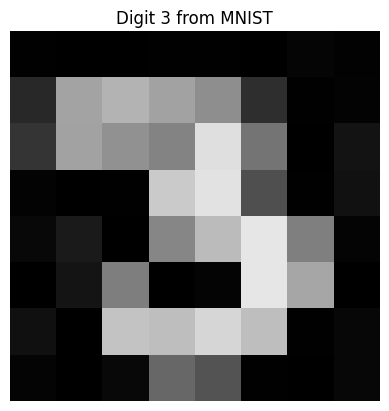

In [17]:
image = utils.plot_image('../images/three_8by8.jpg', 'Digit 3 from MNIST')

In [18]:
def equal_superposition(circ: qiskit.QuantumCircuit, start: int, end: int):
    circ.h([*range(start, end)])
        
def iterate(circ: qiskit.QuantumCircuit, padding: int, current_state: str, next_state: str):
    n = len(current_state)
    
    # Indices we must apply an X gate to go from current_state to next_state 
    #   - We reverse the state strings because we set the coordinates qubits in the circuit
    #       in descending order.
    x_targets = np.array([idx + padding for idx in range(n) 
                          if current_state[idx] != next_state[idx]])
    # Example
    # 1110 -> 1111
    #   if we don't reverse the strings we get:
    #   x_targets = [3]
    #   thus we will apply the X gate on the fourth qubit.
    #   but this is not what we want, we should apply it to the first qubit.
    #   think little endian vs big endian
    
    if x_targets.size > 0:
        circ.x(x_targets)

def pixel_encoding(circ: qiskit.QuantumCircuit, control: list, target: int, intensity: float):
    # Making the C^nRY manually improves visualization
    cry = RYGate(2 * intensity).control(len(control))
    aux = np.append(control, target).tolist()
    circ.append(cry, aux)

In [19]:
im_list = image.flatten()
thetas = np.interp(im_list, (0, 256), (0, np.pi/2)) # intensity matrix
phis = np.interp(range(len(im_list)), (0, len(im_list)), (0, np.pi/2)) # coordinate matrix

In [20]:
num_ind_bits = int(np.ceil(log(len(im_list),2)))
print(num_ind_bits)

6


In [21]:
O = qiskit.QuantumRegister(num_ind_bits, 'o_reg')
c = qiskit.QuantumRegister(1,'c_reg')
p = qiskit.QuantumRegister(1, 'p_reg')
cr = qiskit.ClassicalRegister(O.size+c.size+p.size, "cl_reg")

In [22]:
qc = qiskit.QuantumCircuit(c, p, O, cr)
num_qubits = qc.num_qubits
input_im = image.copy().flatten()
equal_superposition(qc, 1, num_qubits)

In [23]:
controls = list(O) + list(p)

In [ ]:
for i, (phi, theta) in enumerate(zip(phis, thetas)):
    qubit_index_bin = "{0:b}".format(i).zfill(num_ind_bits)
    
    state = '{0:0{1}b}'.format(i-1, num_ind_bits) 
    next_state = '{0:0{1}b}'.format(i, num_ind_bits)
    
    if i > 0:
        iterate(qc, 2, state, next_state)
        
    
    for coord_or_intns in (0,1):
        if not coord_or_intns:
            qc.mcry(theta=2*theta,
                          q_controls=controls,
                          q_target=c[0])
        else:
            qc.x(p)
            qc.mcry(theta=2*phi,
                          q_controls=controls,
                          q_target=c[0])
            if i!=len(thetas) - 1:
                qc.x(p)

    
    qc.barrier()
           
qc.measure(list(reversed(range(qc.num_qubits))), list(range(cr.size)))

/Users/uribagi/Documents/PhD/CVC/quantum-representations-of-classical-data/qrep-env/lib/python3.12/site-packages/numpy/linalg/linalg.py:2180: RuntimeWarning: divide by zero encountered in det
  r = _umath_linalg.det(a, signature=signature)
/Users/uribagi/Documents/PhD/CVC/quantum-representations-of-classical-data/qrep-env/lib/python3.12/site-packages/numpy/linalg/linalg.py:2180: RuntimeWarning: invalid value encountered in det
  r = _umath_linalg.det(a, signature=signature)


In [25]:
qc.draw(output='mpl')

In [26]:
simulator = qiskit_aer.AerSimulator()
circuit = qiskit.transpile(qc, simulator)
shots = 10000
result = simulator.run(circuit, shots=shots).result()

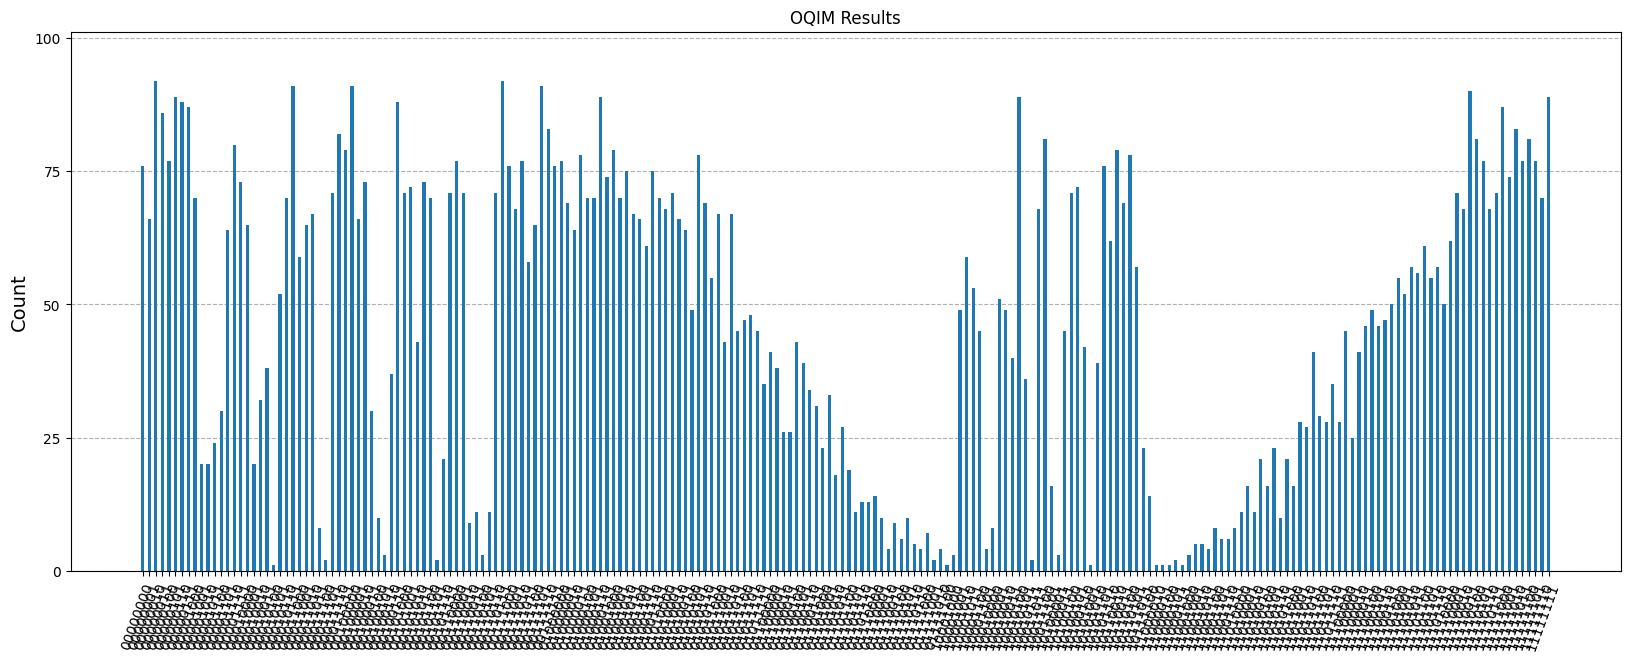

In [27]:
counts = result.get_counts(circuit)
qiskit.visualization.plot_histogram(counts, figsize=(20, 7), title="OQIM Results", bar_labels=False)

In [28]:
ind_list = sorted(range(len(im_list)), key=lambda k:im_list[k])
max_index = max(ind_list)

In [29]:
classical_colors = []
classical_coords = []
for i in range(0, max_index+1):
    color_list = []
    coord_list = []
    for item in counts.items():
        key = item[0]
        amount = item[1]
        bin_coord = key[2:]
        int_coord = int(bin_coord, 2)
        if int_coord == i:
            if not int(key[1]): # only difference
                color_list.append((key[0], amount))
            else:
                coord_list.append((key[0], amount))
    color_amount = 0
    for color, amount in color_list:
        if not int(color):
            color_amount=color_amount+amount
    try:
        color = np.arccos((color_amount/sum(n for _, n in color_list))**(1/2))
        classical_colors.append(color)
    except ZeroDivisionError:
        print("ZeroDivisionError")
        
    coord_amount = 0
    for coord, amount in coord_list:
        if not int(coord):
            coord_amount=coord_amount+amount
    try:
        coord = np.arccos((coord_amount/sum(n for _, n in coord_list))**(1/2))
        classical_coords.append(coord)
    except ZeroDivisionError:
        print("ZeroDivisionError")
classical_colors = np.interp(classical_colors, (0, np.pi/2), (0, 256)).astype(int)
classical_coords = np.interp(classical_coords, (0, np.pi/2), (0, len(im_list))).astype(int)
output_im = classical_colors.reshape(image.shape)

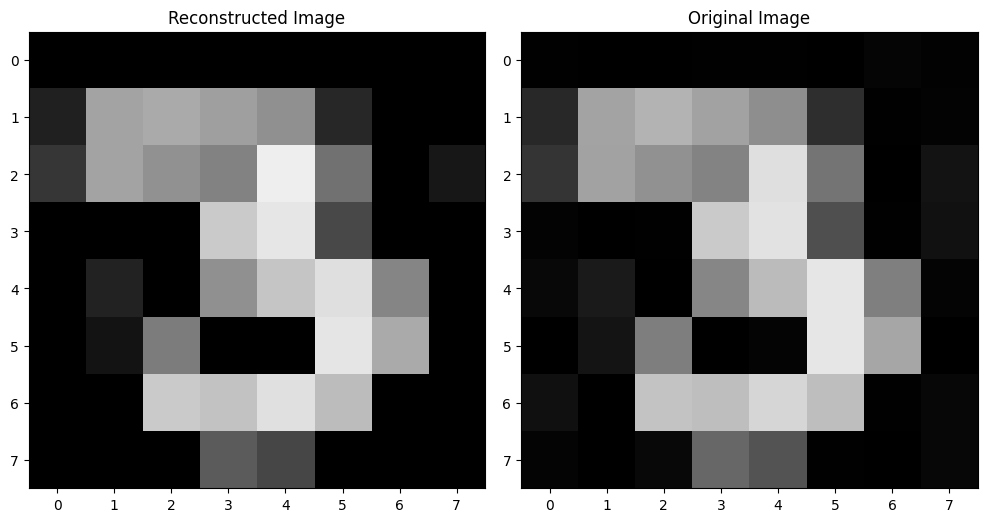

In [30]:
fig, axs = plt.subplots(1, 2, figsize=(10, 5))

axs[0].imshow(output_im, cmap='gray', vmin=0, vmax=255)
axs[0].set_title('Reconstructed Image')
axs[1].imshow(image, cmap='gray', vmin=0, vmax=255)
axs[1].set_title('Original Image')

plt.tight_layout()